# Анализ окупаемости каналов привлечения пользователей

<b>Задача для маркетингового аналитика</b> развлекательного приложения Procrastinate Pro+. По условиям задачи несколько прошлых месяцев  бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Необходимо разобраться в причинах этой ситуации.

<b>Задача - изучить</b>: 
- как люди пользуются продуктом;
- когда они начинают покупать;
- сколько денег приносит каждый клиент;
- когда он окупается;
- какие факторы отрицательно влияют на привлечение пользователей.

<b>Описание данных:</b>
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день
    
    
<b>Ключевые выводы:</b>

Причины неэффективности:

- Причина неэффективности достаточно очевидна. С опорой, видимо, в основном на такие показатели как LTV и доля платежеспособной аудитории, была сделана ставка на пользователей из США с техникой Apple через Тип-Топ. Однако, стоимость привлечения одного клиента через данный канал в разы превосходит все остальные. В связи с этим даже действительно высокий LTV среди данных категорий пользователей не смог оправдать затрат на их привлечение.

- Несколько меньшая проблема - это низкое качество клиентов, приводимых Фейсбумом и Аднонсенсом - двумя другими крупными каналами рекламы. Эти каналы дешевле, у них лучше конверсия, но гораздо меньше удержание.

Рекомендации:

- Перестать держать Тип-Топ в качестве приоритетного канала рекламы - он слишком дорогой, а пользователи, пришедшие через него демонстрируются слишком средние результаты, не позволяющие окупать инвестиции в них.
- В краткосрочной перспективе поддерживать инвестиции в Фейсбум на текущем уровне, так как он крупный канал, который все-таки окупается. В долгосрочной необходимо понять, почему клиенты, пришедшие через него так быстро уходят, и либо решить проблему, либо уменьшить приоритет данного канала.
- В долгосрочной перспективе наращивать инвестиции в другие каналы рекламы, обладающие лучшими показателями, например, в YRabbit, MediaTornado, LambdaMediaAds.

<a id="table_of_contest"></a>

<b>Оглавление:<b>
1. [Открытие данных](#start)
2. [Подготовка функций для анализа](#functions)
3. [Исследовательский анализ данных](#research)
4. [Маркетинг](#marketing)
5. [Исследование окупаемости](#profit)
    * [Общая окупаемость](#whole_profit)
    *[Окупаемость в разрезе устройств](#by_device)
    *[Окупаемость в разрезе стран](#by_country)
    *[Окупаемость в разрезе рекламных каналов](#by_channels)
6. [Вывод](#final_step)

[Вернуться к оглавлению](#table_of_contest)

<a id="start"></a>

# Открытие данных
Загрузка данных о визитах, заказах и расходах в переменные. Оптимизация данных для анализа.

In [1]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

Импортируем библиотеки

In [2]:
#функция для подгрузки массивов с гугл диска
def google_downloader(url):
    file_id=url.split('/')[-2]
    dwn_url='https://drive.google.com/uc?id=' + file_id
    df = pd.read_csv(dwn_url, parse_dates = True)
    return df

In [3]:
visits = google_downloader('https://drive.google.com/file/d/1NS_GQl-iUPQCWI8482CQsQH4kdU9sfnH/view?usp=sharing')
orders = google_downloader('https://drive.google.com/file/d/1gaXwvPAoWh70xGc7G5yxb1qe7TwBzoKR/view?usp=sharing')
costs = google_downloader('https://drive.google.com/file/d/1IC_MAGyaWi1AhiDxNjD_okQhZjo45aTS/view?usp=sharing')

Подгружаем файлы

In [4]:
print ('visits')
display(visits.head())
print ('-----------------------------------')
print ('orders')
display(orders.head())
print ('-----------------------------------')
print ('costs')
display(costs.head())

visits


User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

-----------------------------------
orders


User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

-----------------------------------
costs


dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

Осматриваем данные

In [5]:
visits.rename(columns={'User Id': 'id'}, inplace=True)
visits.rename(columns={'Session Start': 'session_start'}, inplace=True)
visits.rename(columns={'Session End': 'session_end'}, inplace=True)
visits.rename(columns={'Region': 'region'}, inplace=True)
visits.rename(columns={'Device': 'device'}, inplace=True)
visits.rename(columns={'Channel': 'channel'}, inplace=True)
orders.rename(columns={'User Id': 'id'}, inplace=True)
orders.rename(columns={'Event Dt': 'event_dt'}, inplace=True)
orders.rename(columns={'Revenue': 'revenue'}, inplace=True)
costs.rename(columns={'Channel': 'channel'}, inplace=True)

Даем нормальные названия столбцам

In [6]:
visits['session_start'] = pd.to_datetime(visits['session_start']).dt.date
visits['session_end'] = pd.to_datetime(visits['session_end']).dt.date
orders['event_dt'] = pd.to_datetime(orders['event_dt']).dt.date
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [7]:
print ('visits')
display(visits.info())
print ('-----------------------------------')
print ('orders')
display(orders.info())
print ('-----------------------------------')
print ('costs')
display(costs.info())

visits
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

-----------------------------------
orders
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

-----------------------------------
costs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

In [8]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt'])

In [9]:
print ('visits')
display(visits.info())
print ('-----------------------------------')
print ('orders')
display(orders.info())
print ('-----------------------------------')
print ('costs')
display(costs.info())

visits
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


None

-----------------------------------
orders
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


None

-----------------------------------
costs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB


None

Приводим столбцы с датами к нормальному формату

In [10]:
visits.info(memory_usage='deep')
costs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 64.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 147.8 KB


Все столбцы с устройства, каналами, странами и т.д. стандартизированы. Следовательно, мы можем изменить им тип данных на категориальный для экономии памяти.

In [11]:
visits['region'] = visits['region'].astype('category')
visits['device'] = visits['device'].astype('category')
visits['channel'] = visits['channel'].astype('category')
costs['channel'] = costs['channel'].astype('category')

In [12]:
visits.info(memory_usage='deep')
costs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             309901 non-null  int64         
 1   region         309901 non-null  category      
 2   device         309901 non-null  category      
 3   channel        309901 non-null  category      
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: category(3), datetime64[ns](2), int64(1)
memory usage: 8.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   category      
 2   costs    1800 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(1)
memory usage: 31.0 KB


Удалось сэкономить около 3/4 памяти в visits и 6/10 в costs.

Больше типы данных можно не менять, далее нужно найти пропуски и удалить дубликаты

In [13]:
def miss_table(data):
    missings = pd.DataFrame(data.isna().mean()*100, columns = ['% miss'])
    missings['# miss'] = pd.DataFrame(data.isna().sum())
    display (missings.style.background_gradient('coolwarm'))

In [14]:
miss_table(visits)
miss_table(orders)
miss_table(costs)

Пропуски отсутствуют 

In [15]:
print ('visits')
print (visits.duplicated().sum())
print ('-----------------------------')
print ('orders')
print(orders.duplicated().sum())
print ('-----------------------------')
print ('costs')
print(costs.duplicated().sum())

visits
0
-----------------------------
orders
2
-----------------------------
costs
0


найдено два дубликата в costs

In [16]:
orders = orders.drop_duplicates().reset_index(drop = True)

Дубликаты удалены, данные готовы к анализу

[Вернуться к оглавлению](#table_of_contest)

<a id="functions"></a>

# Подготовка функций для анализа

In [17]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40210 entries, 0 to 40209
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        40210 non-null  int64         
 1   event_dt  40210 non-null  datetime64[ns]
 2   revenue   40210 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.5 KB


Функции для получения необходимых нам дата фреймов и их визуализации

In [18]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['id', 'session_start'])
        .groupby('id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = pd.to_datetime(profiles['first_ts'])
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['id'].isin(orders['id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'id': 'nunique'})
        .rename(columns={'id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [19]:
# функция для расчёта удержания

def get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        visits[['id', 'session_start']], on='id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'id': 'nunique'})
            .rename(columns={'id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [20]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        orders.sort_values(by=['id', 'event_dt'])
        .groupby('id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['id', 'event_dt']], on='id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'id': 'nunique'})
            .rename(columns={'id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [21]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        orders[['id', 'event_dt', 'revenue']], on='id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'id': 'nunique'})
            .rename(columns={'id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [22]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [23]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [24]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [25]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

[Вернуться к оглавлению](#table_of_contest)

<a id="research"></a>

# Исследовательский анализ данных

Построение профилей пользователей. Определение минимальной и максимальной даты привлечения пользователей.

Вопросы:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [26]:
profiles = get_profiles(visits, orders, costs)

In [27]:
display (profiles.head())

id   first_ts     channel  device         region         dt  \
0    599326 2019-05-07    FaceBoom     Mac  United States 2019-05-07   
1   4919697 2019-07-09    FaceBoom  iPhone  United States 2019-07-09   
2   6085896 2019-10-01     organic  iPhone         France 2019-10-01   
3  22593348 2019-08-22  AdNonSense      PC        Germany 2019-08-22   
4  31989216 2019-10-02     YRabbit  iPhone  United States 2019-10-02   

       month  payer  acquisition_cost  
0 2019-05-01   True          1.088172  
1 2019-07-01  False          1.107237  
2 2019-10-01  False          0.000000  
3 2019-08-01  False          0.988235  
4 2019-10-01  False          0.230769

In [28]:
print ('Минимальная дата привлечения пользователя в массиве - это {}'.format(profiles['first_ts'].min()))
print ('Максимальная дата привлечения пользователя в массиве - это {}'.format(profiles['first_ts'].max()))

Минимальная дата привлечения пользователя в массиве - это 2019-05-01 00:00:00
Максимальная дата привлечения пользователя в массиве - это 2019-10-27 00:00:00


In [29]:
def pie_cat(df, category, name, value, func): 
    plt.figure(figsize=(30, 15))

    ax1 = plt.subplot(1, 2, 1)
    df.pivot_table(index = category, values = value, aggfunc = func).plot.pie(y=value, figsize=(15, 15), autopct="%.1f%%", ax = ax1)
    plt.legend()
    plt.title('Доля разных {} в общем числе пользователей'.format(name))

    ax2 = plt.subplot(1, 2, 2)
    df.query('payer == True').pivot_table(index = category, values = value, aggfunc = func).plot.pie(y=value, figsize=(15, 15), autopct="%.1f%%", ax = ax2)
    plt.legend()
    plt.title('Доля разных {} в общем числе платящих пользователей'.format(name))

    plt.tight_layout()
    plt.show()

In [30]:
def table_cat(profiles, category):    
    device_users = profiles.pivot_table(
        index = category, 
        values = 'id', 
        aggfunc = 'count', 
        margins = True).merge(
        profiles.query('payer == True').pivot_table(
            index = category, 
            values = 'id', 
            aggfunc = 'count', 
            margins = True), on = category)

    device_users.columns = ['All', 'Payers']

    device_users['Payers']=device_users['Payers']/device_users['All']*100

    display(device_users)

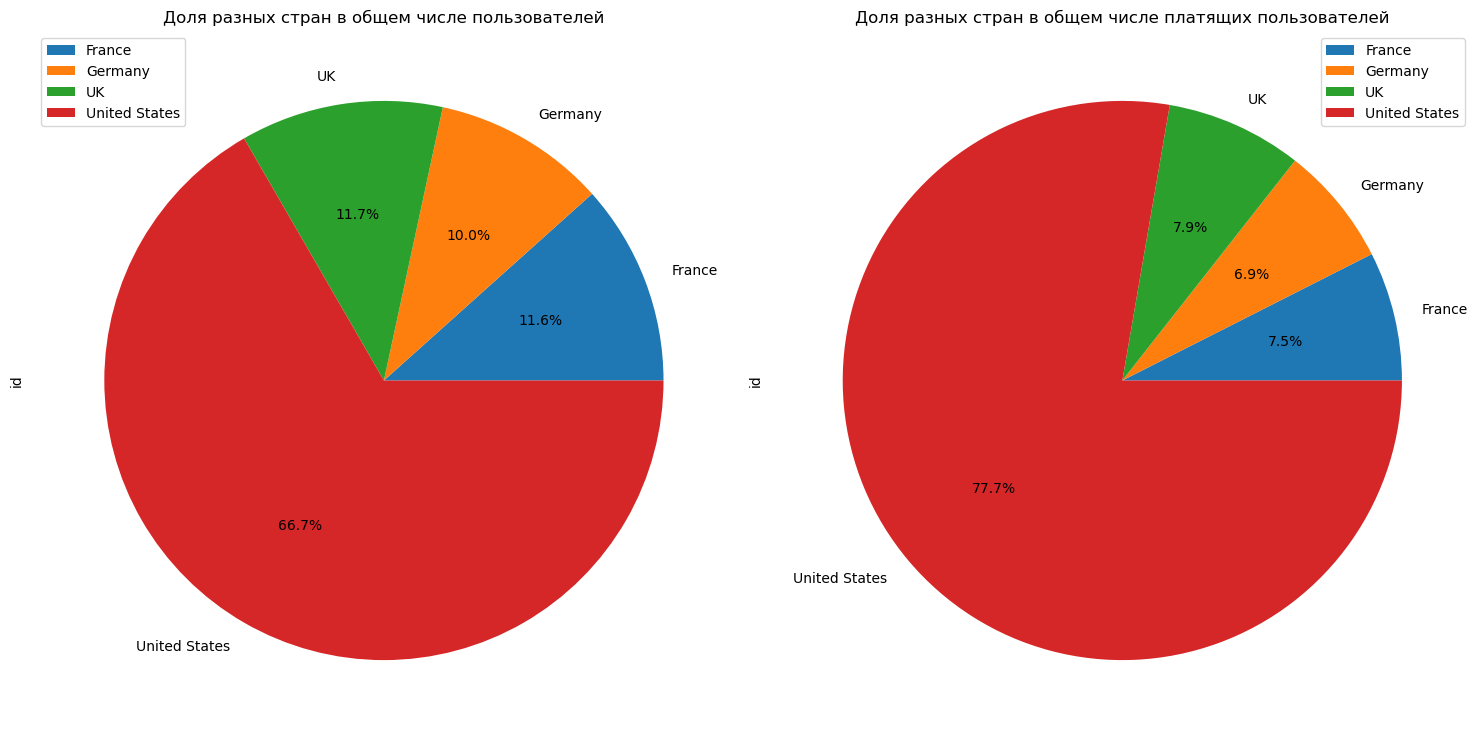

In [31]:
pie_cat(profiles, 'region', 'стран', 'id', 'count')

In [32]:
table_cat(profiles, 'region')

All    Payers
region                         
France          17450  3.799427
Germany         14981  4.111875
UK              17575  3.982930
United States  100002  6.901862
All            150008  5.920351

В США большая доля платящих пользователей относительно других стран массива. 

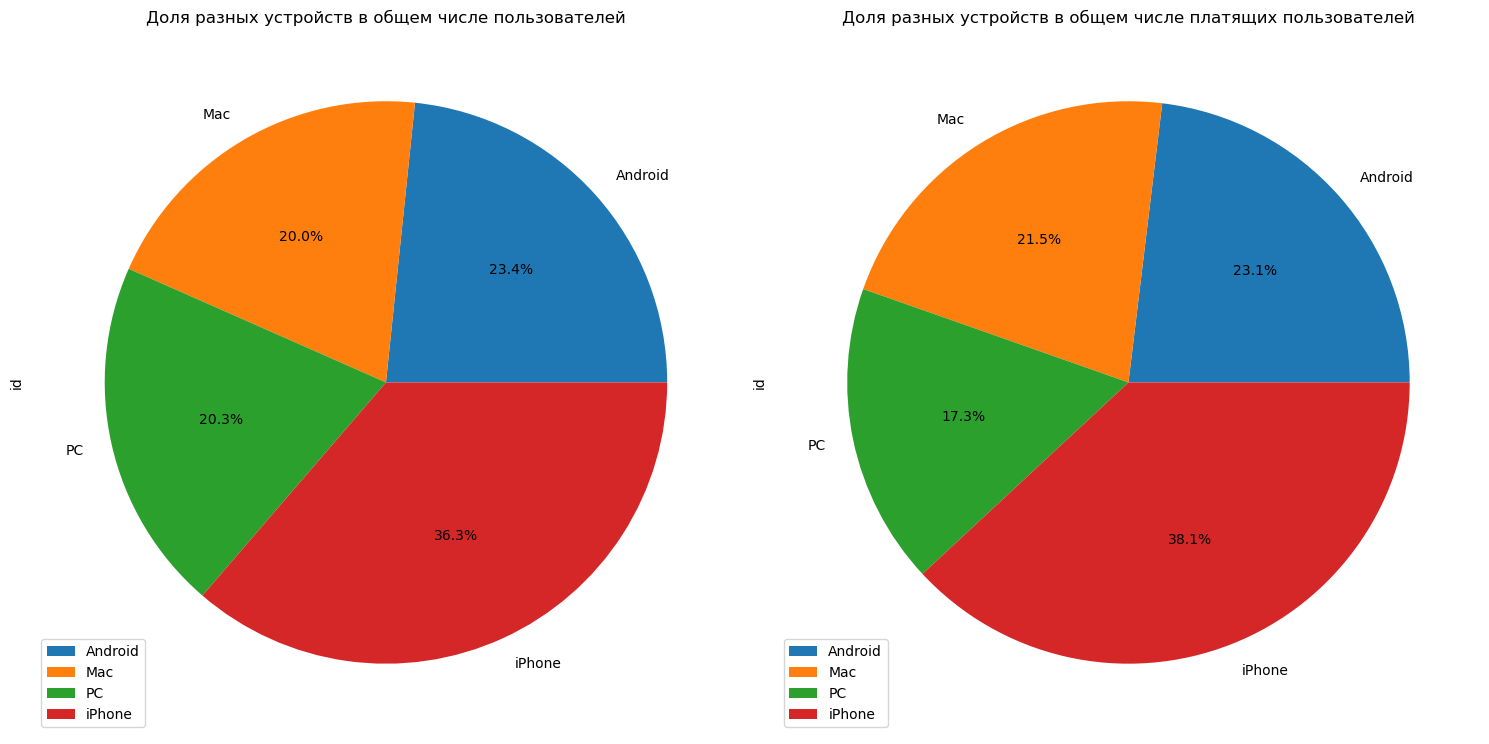

In [33]:
pie_cat(profiles, 'device', 'устройств', 'id', 'count')

In [34]:
table_cat(profiles, 'device')

All    Payers
device                   
Android   35032  5.851793
Mac       30042  6.364423
PC        30455  5.046790
iPhone    54479  6.207897
All      150008  5.920351

В массиве 4 типа устройств - Андроид, Айфон, ПК и Мак. На ПК - менее платежеспособная аудитория, на устройствах Apple - более платежеспособная.

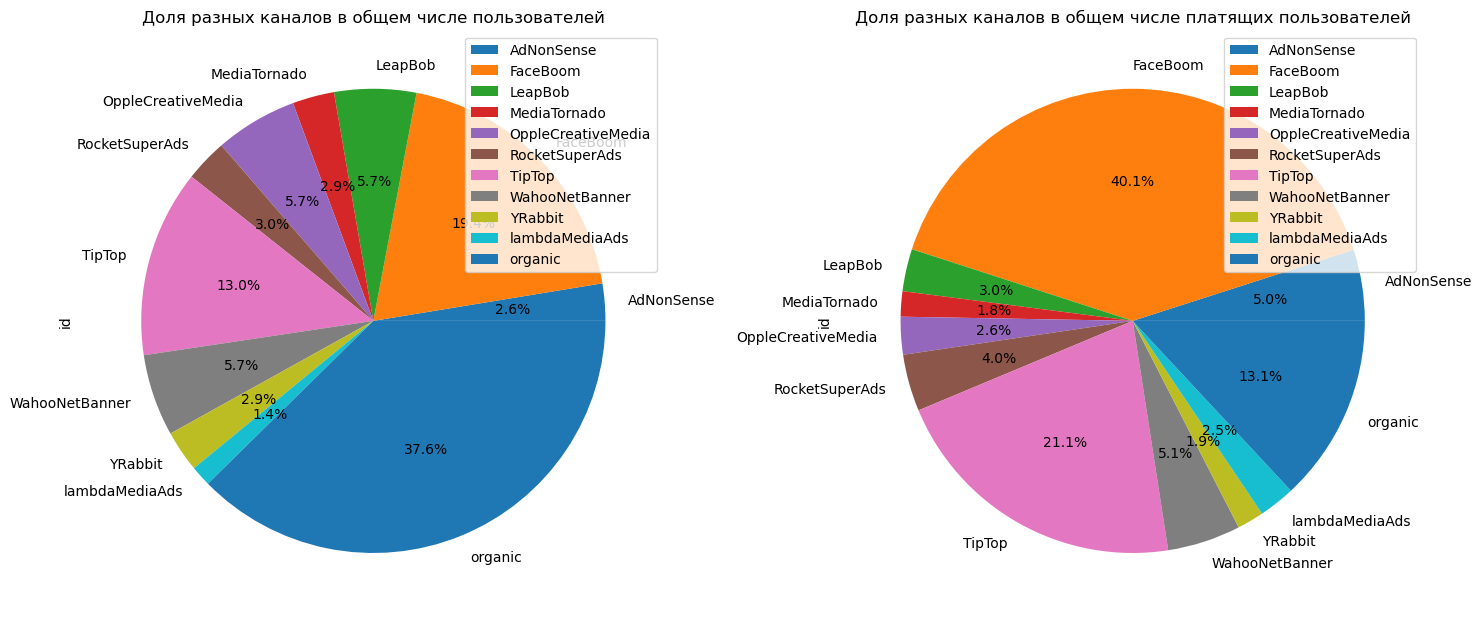

In [35]:
pie_cat(profiles, 'channel', 'каналов', 'id', 'count')

In [36]:
table_cat(profiles, 'channel')

All     Payers
channel                              
AdNonSense            3880  11.340206
FaceBoom             29144  12.204914
LeapBob               8553   3.063253
MediaTornado          4364   3.574702
OppleCreativeMedia    8605   2.707728
RocketSuperAds        4448   7.913669
TipTop               19561   9.600736
WahooNetBanner        8553   5.296387
YRabbit               4312   3.826531
lambdaMediaAds        2149  10.469986
organic              56439   2.055316
All                 150008   5.920351

Всего в массиве есть данные по 11 каналам. Наибольшие - органик и фейсбум, при этом среди платящих пользователей доля органиков меньше, а фейсбум наоборот показывает хорошие результаты, аналогично с AdNonSense. Тип-топ не настолько хорош. У остальных каналов доля либо слишком мала, либо изменяется незначительно. 

<b>Предварительные выводы:<b>
    
    * Наиболее платетежспособная аудитория находится в США, пользуется устройствами Apple и привлечена через Фейсбум
    * Тип-топ выглядит как не самый лучший канал привлечения аудитории

[Вернуться к оглавлению](#table_of_contest)

<a id="marketing"></a>

# Маркетинг

Вопросы:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

In [37]:
print ('Всего на рекламу потратили {:.1f} долларов'.format(costs['costs'].sum()))

Всего на рекламу потратили 105497.3 долларов


In [38]:
costs.head()

dt   channel  costs
0 2019-05-01  FaceBoom  113.3
1 2019-05-02  FaceBoom   78.1
2 2019-05-03  FaceBoom   85.8
3 2019-05-04  FaceBoom  136.4
4 2019-05-05  FaceBoom  122.1

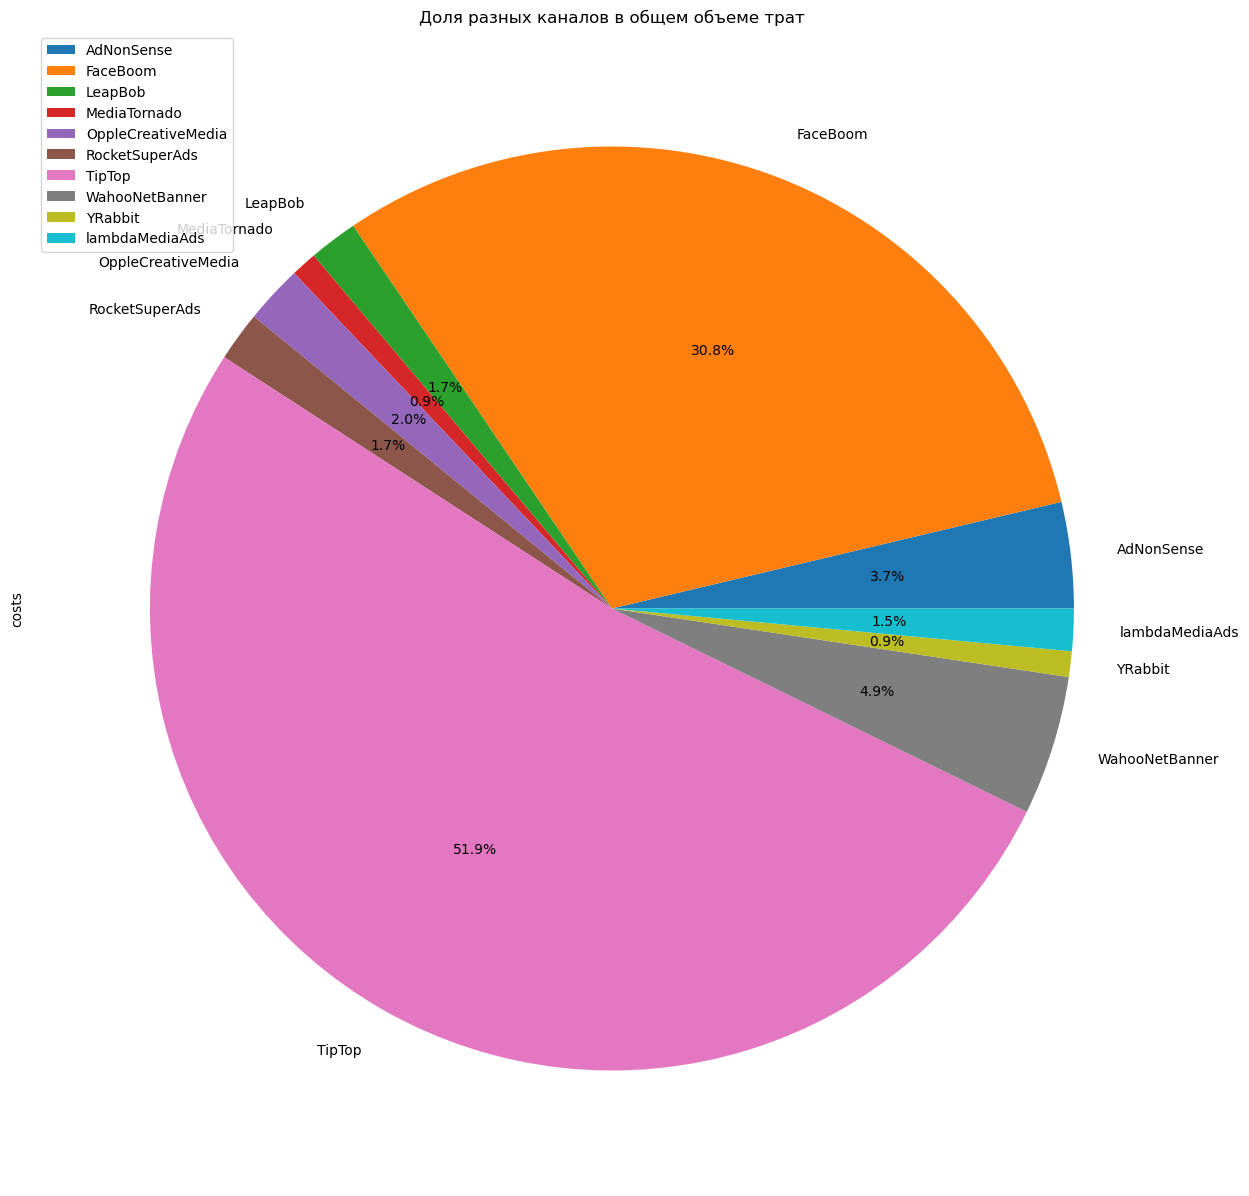

In [39]:
costs.pivot_table(index = 'channel', values = 'costs', aggfunc = 'sum').plot.pie(y='costs', figsize=(15, 15), autopct="%.1f%%")
plt.legend()
plt.title('Доля разных каналов в общем объеме трат')

plt.show()

Тип Топ забирает больше половины рекламного бюджета, второй - Фейсбум с 30%. При сопоставлении с графиками выше по числу пользователей и числу платящих пользователей уже сейчас можно предположить, что с Тип Топом что-то не так.

In [40]:
costs_by_time = costs.pivot_table(index = 'dt', columns = 'channel', values = 'costs', aggfunc = 'sum')

<AxesSubplot:xlabel='dt'>

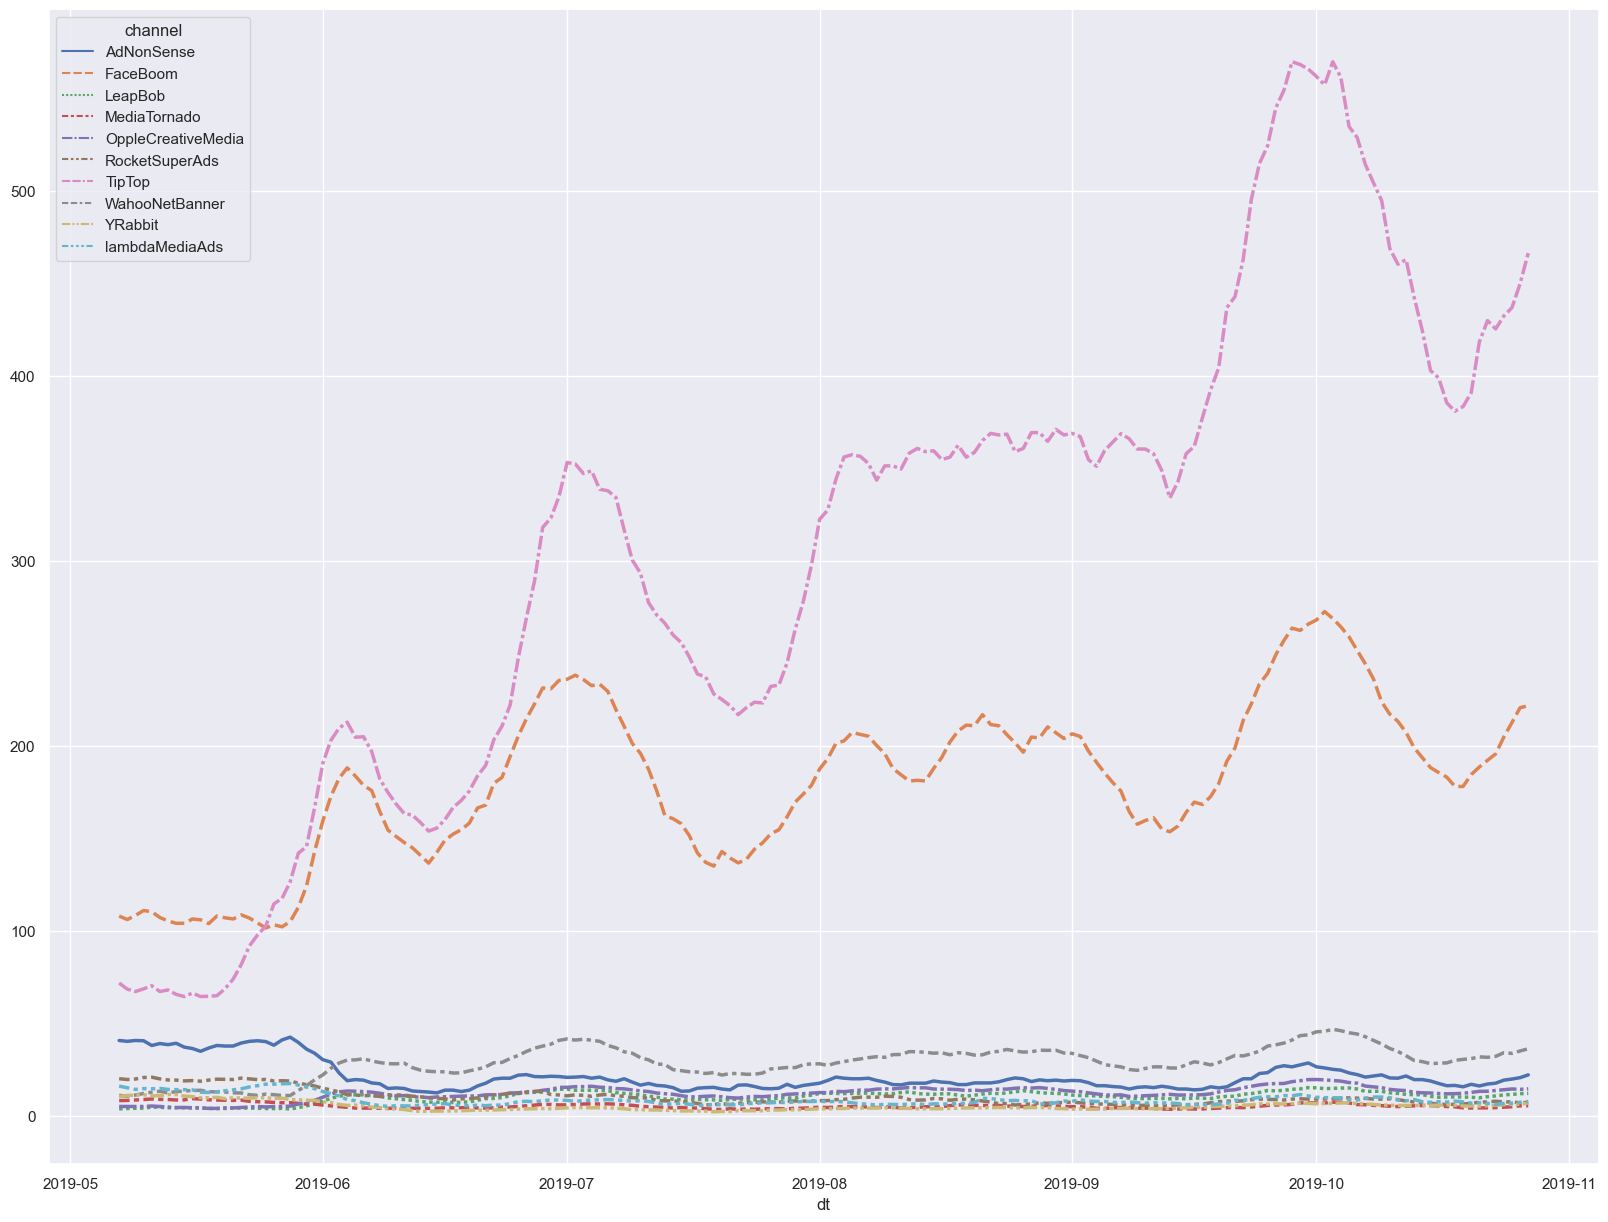

In [41]:
sns.set(rc={'figure.figsize':(20,15)})
sns.lineplot(data=filter_data(costs_by_time, 7), linewidth=2.5)

Изначально расходы на главные каналы рекламы - фейсбум и тип-топ были не сильно больше остальных, но потом начали стремительно расти, при этом Тип-топ быстро обогнал фейсбум и продолжил расти, в то время как расходы на фейсбум в общем-то оставали относительно стабильными.

C:\Users\CaIII\AppData\Local\Temp\ipykernel_28076\418270559.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  sns.lineplot(data=filter_data(costs_by_time.drop(['FaceBoom', 'TipTop'], 1), 7), linewidth=2.5, legend = 'full')


<AxesSubplot:xlabel='dt'>

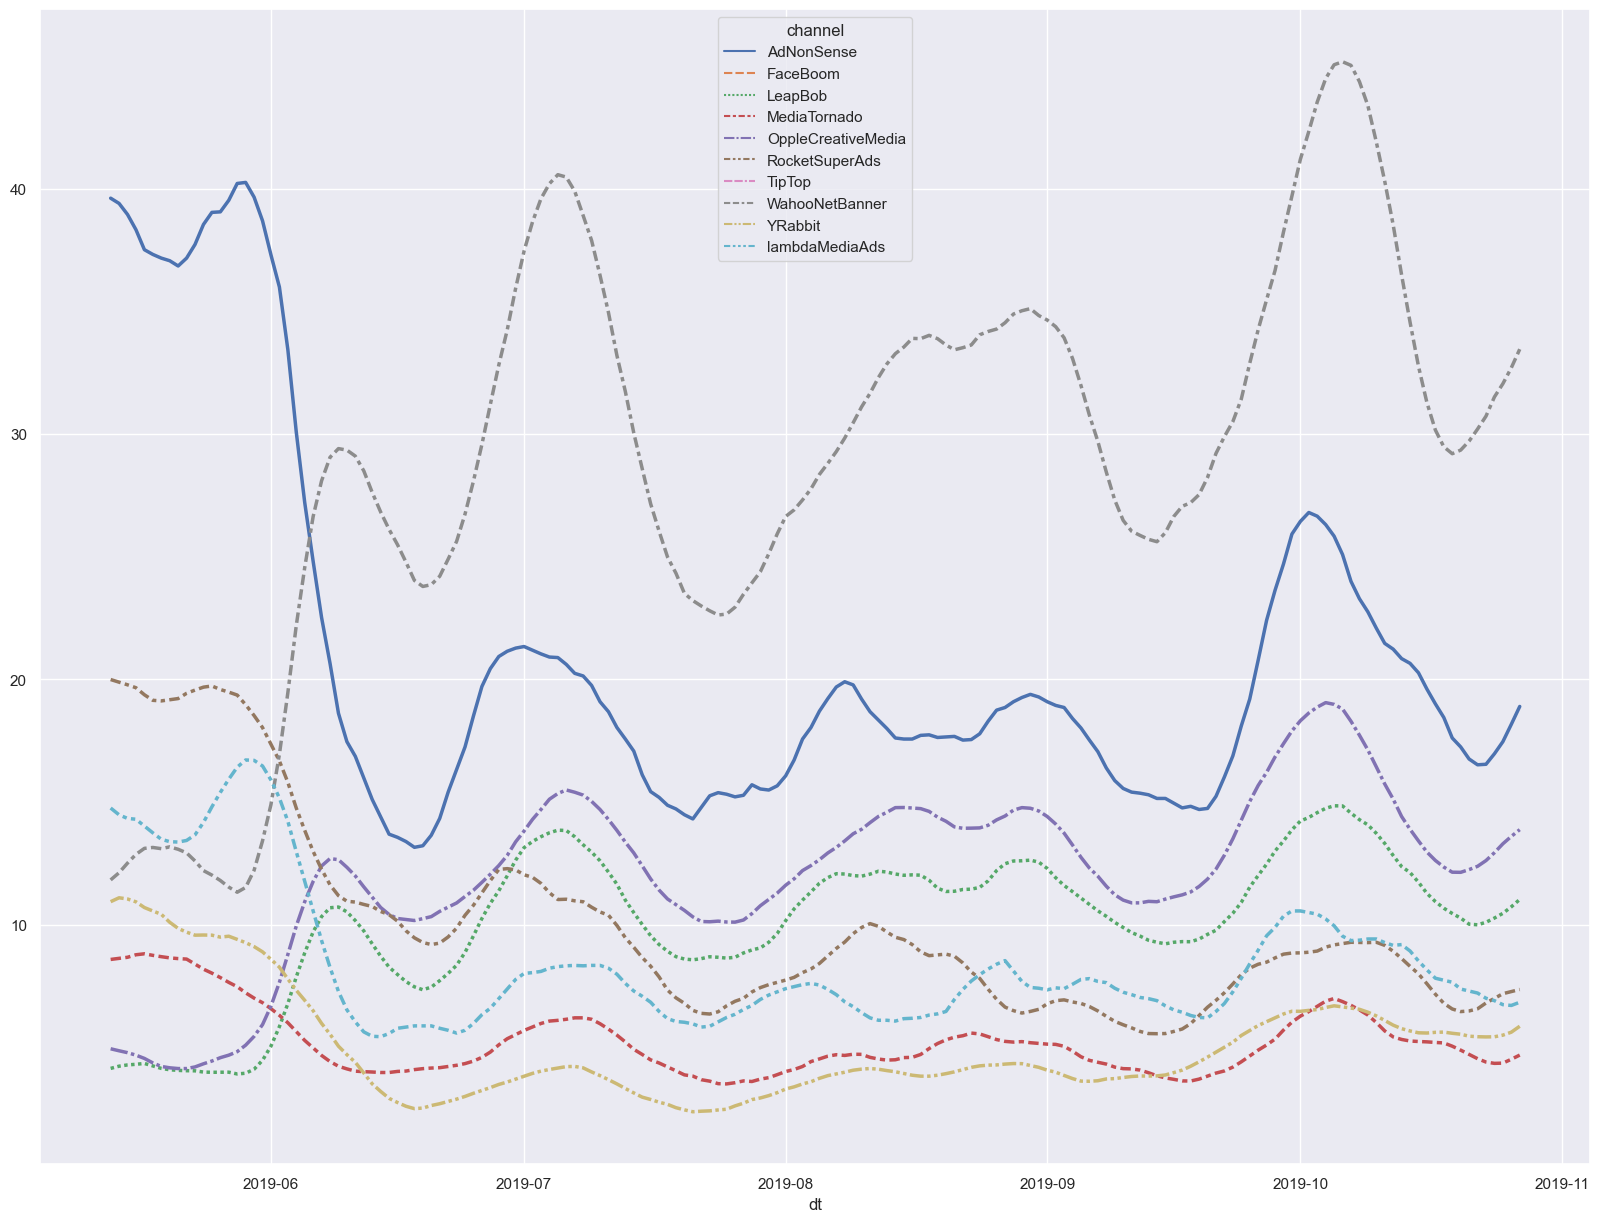

In [42]:
sns.set(rc={'figure.figsize':(20,15)})
sns.lineplot(data=filter_data(costs_by_time.drop(['FaceBoom', 'TipTop'], 1), 7), linewidth=2.5, legend = 'full')

Среди каналов рекламы поменьше также случилась смена лидеров. Расходы на AdNonSense резко упали, а выросли они на WahooNetBanner.

In [43]:
print('В среднем привлечение одного пользователя стоило {:.2f} долларов.'.format(profiles['acquisition_cost'].mean()))

В среднем привлечение одного пользователя стоило 0.70 долларов.


In [44]:
print(profiles.groupby('channel')['acquisition_cost'].mean())

channel
AdNonSense            1.008054
FaceBoom              1.113286
LeapBob               0.210172
MediaTornado          0.218717
OppleCreativeMedia    0.250000
RocketSuperAds        0.412095
TipTop                2.799003
WahooNetBanner        0.602245
YRabbit               0.218975
lambdaMediaAds        0.724802
organic               0.000000
Name: acquisition_cost, dtype: float64


<AxesSubplot:xlabel='channel'>

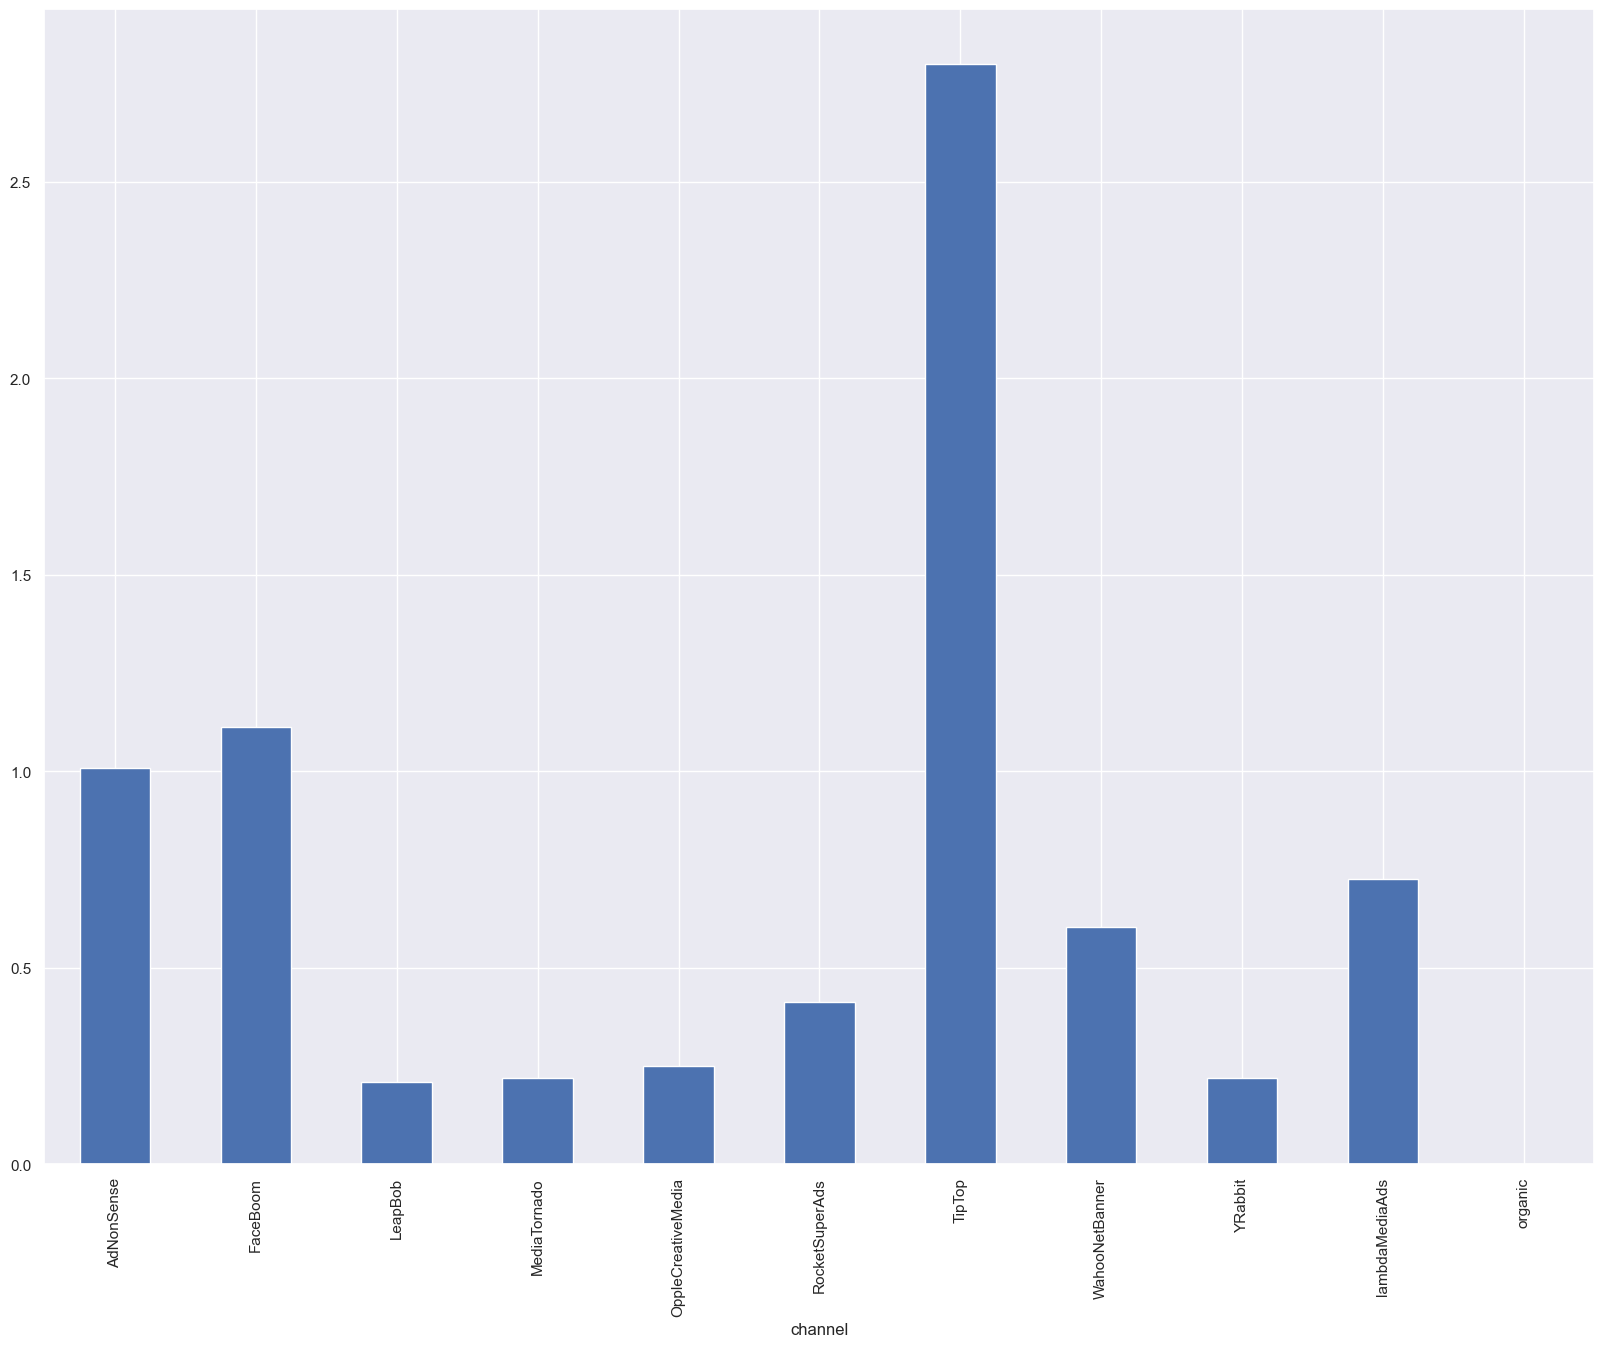

In [45]:
profiles.groupby('channel')['acquisition_cost'].mean().plot.bar()

Стоимость привлечения одного пользователя и Тип-Топ самая большая из всех каналов. 

<b>Промежуточный вывод: <b>
    
Тип-топ вызывает все больше вопросов. Привлеченные через него клиенты должны тратить очень много денег, чтобы он окупался.

[Вернуться к оглавлению](#table_of_contest)

<a id="profit"></a>

# Оценка окупаемости рекламы для привлечения пользователей

С помощью LTV и ROI анализируем:
- Общую окупаемость рекламы;
- Окупаемость рекламы с разбивкой по устройствам;
- Окупаемость рекламы с разбивкой по странам;
- Окупаемость рекламы с разбивкой по рекламным каналам.

Вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

При описании обнаруженных проблем считаем, что смотрим данные 1-го ноября 2019 года и что в организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

[Вернуться к оглавлению](#table_of_contest)

<a id="whole_profit"></a>

### Общая окупаемость рекламы

In [46]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа

In [47]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history  = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
)

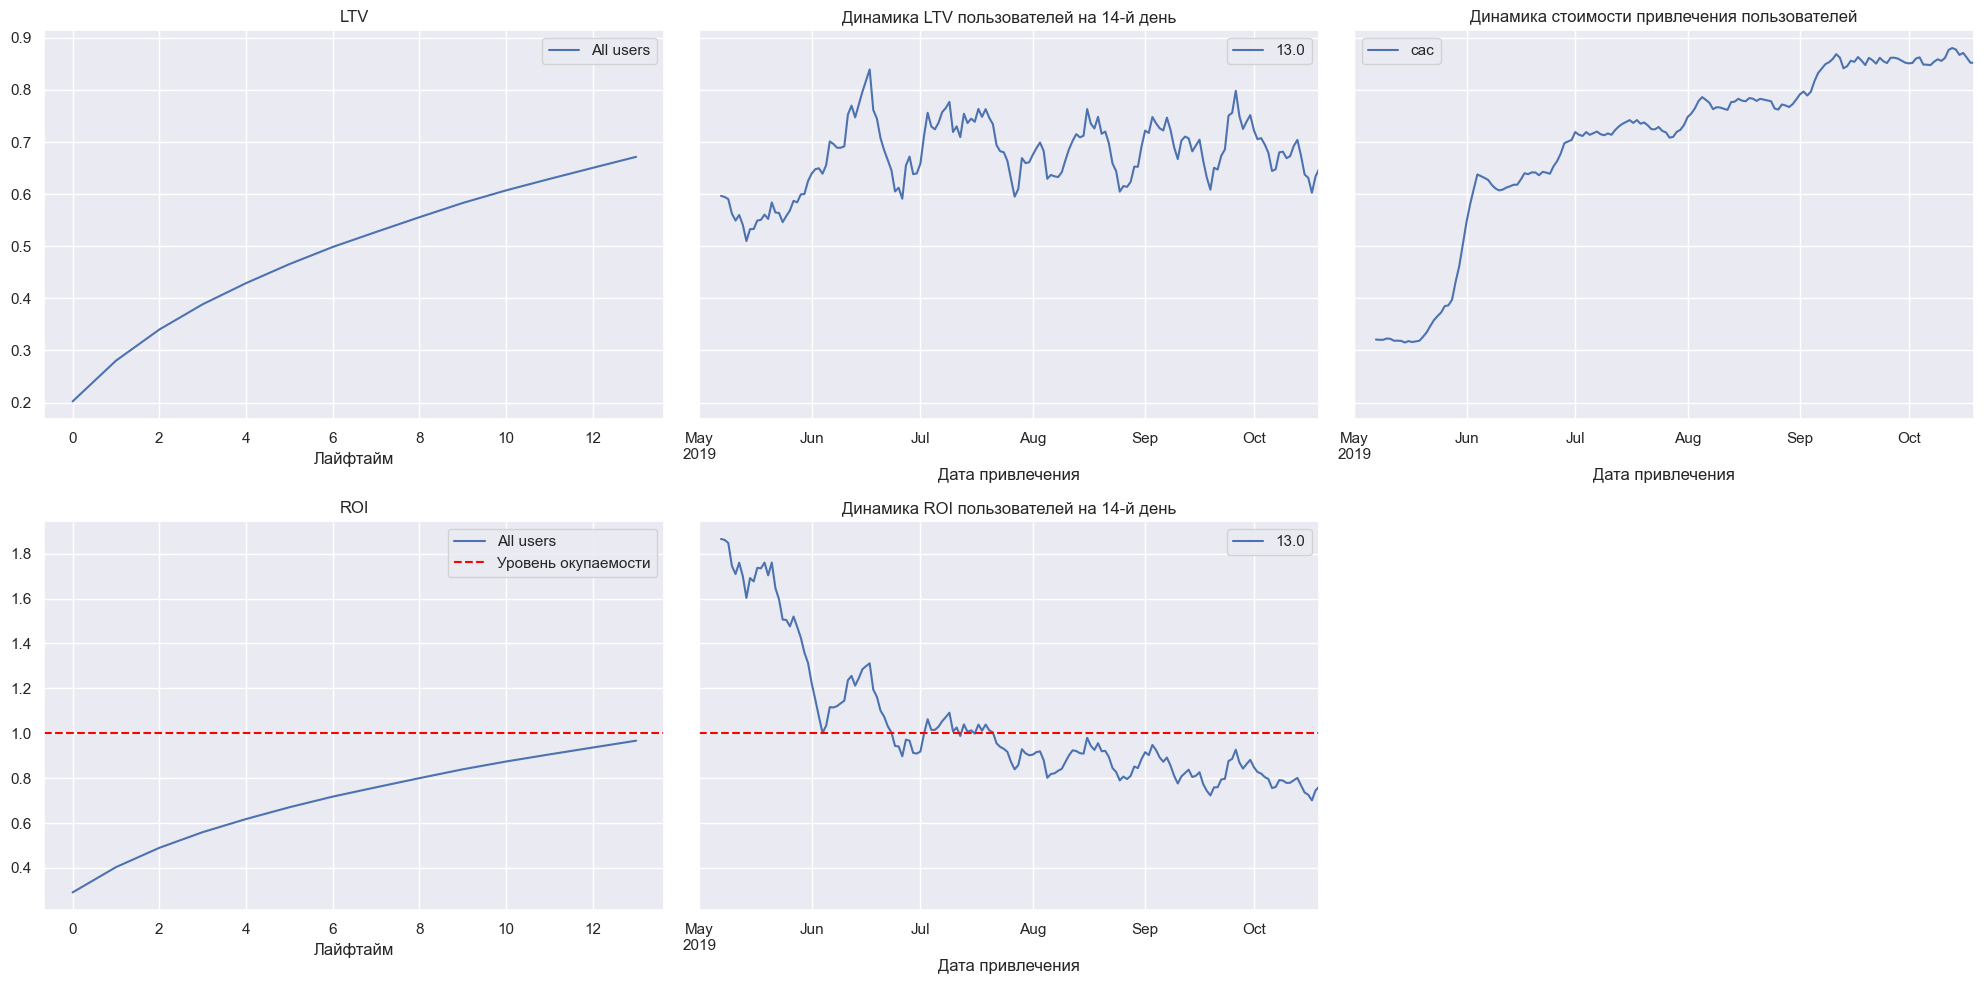

In [48]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

В среднем по массиву ROI не достигает уровня окупаемости, в том числе и на 14 день. При этом очевидно, что причиной тому стал рост расходов на рекламу в июне, который совпал с падением ROI. В этот период, как показано в предыдущих разделах как раз происходит рост вложений в Фейсбум и Тип-Топ. 

In [49]:
result_raw, result_grouped, result_in_time = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
)

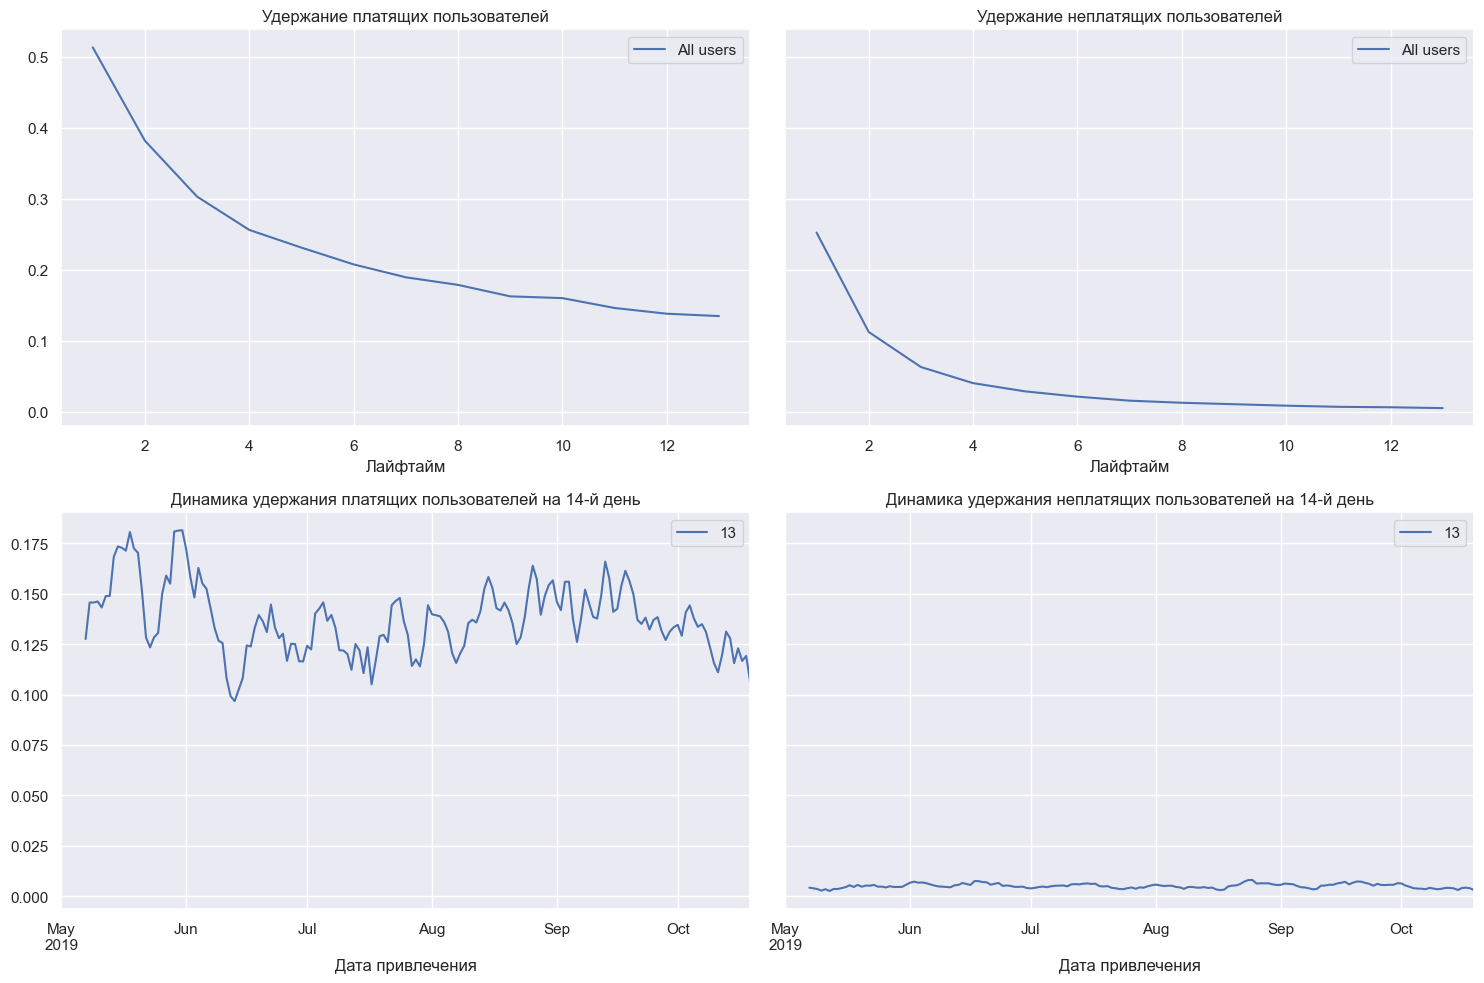

In [50]:
plot_retention(result_grouped, result_in_time, horizon_days, window=7)

Стандартно удержание платных пользователей лучше, чем у бесплатных. Уровень удержания со временем остается относительно стабильным. Он несколько упал относительно первоначальных значений с началом активной рекламной кампании в июне, но в целом не претерпел значимых изменений на протяжении всего обозреваемого периода. Однако, в разрезе по отдельным параметрам, мы можем найти внутренние различия.

In [51]:
result_raw, result_grouped, result_in_time = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
)

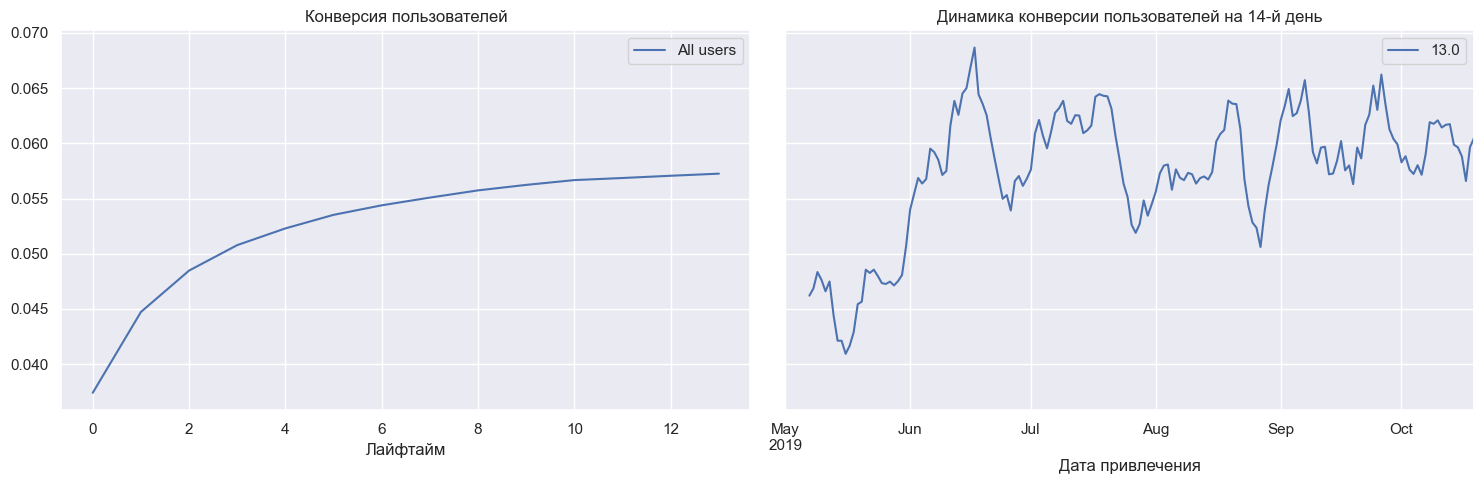

In [52]:
plot_conversion(result_grouped, result_in_time, horizon_days, window=7)

Конверсия значимо взлетела после старта активной рекламной кампании.

[Вернуться к оглавлению](#table_of_contest)

<a id="by_device"></a>

### Проанализируйте окупаемость рекламы с разбивкой по устройствам

In [53]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history  = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['device'],
    ignore_horizon=False,
)

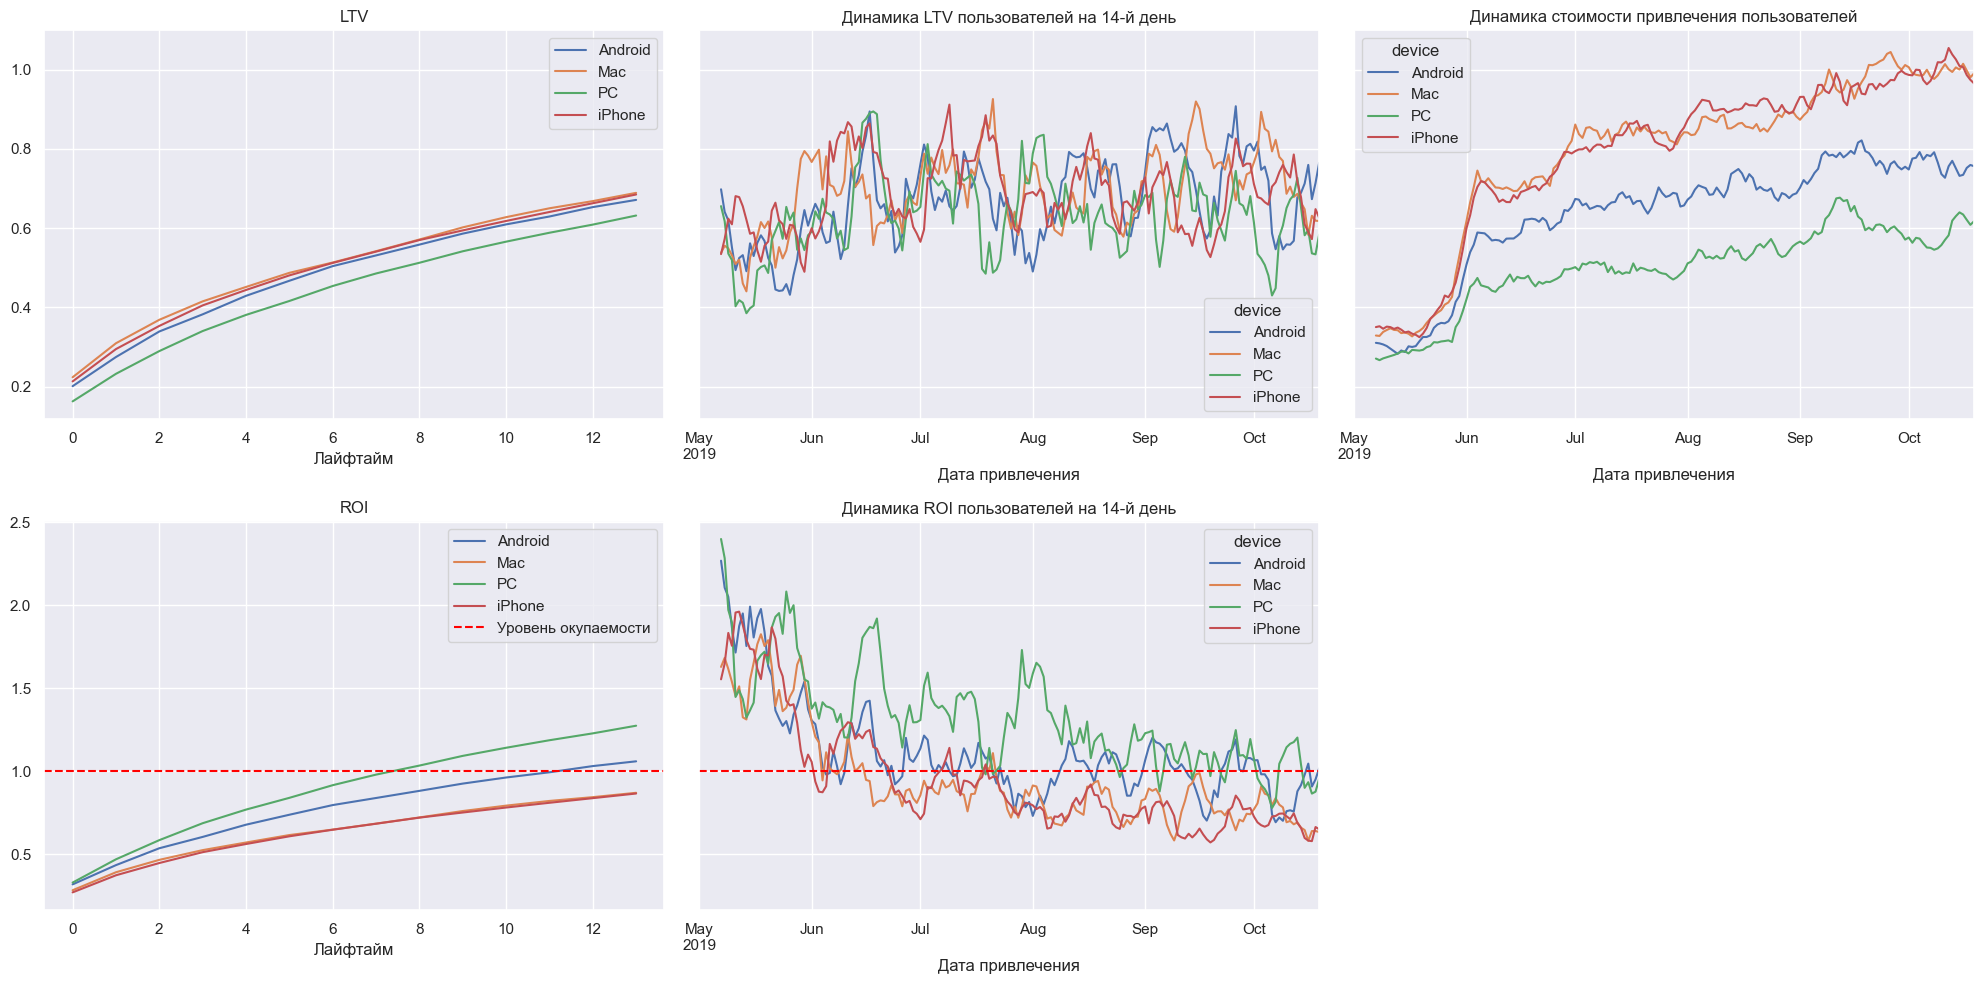

In [54]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Несмотря на то, что устройства Apple демонстрируют большую долю платящей аудитории и больший LTV, а PC - ровно наоборот, стоимость привлечения яблочников радикально выше и именно у них ROI в итоге вообще не дотягивает до окупаемости. На ПК же в свою очередь даже в самые последние месяцы ROI на 14 день превышал минимальный порог окупаемости.  

In [55]:
result_raw, result_grouped, result_in_time = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=['device'],
    ignore_horizon=False,
)

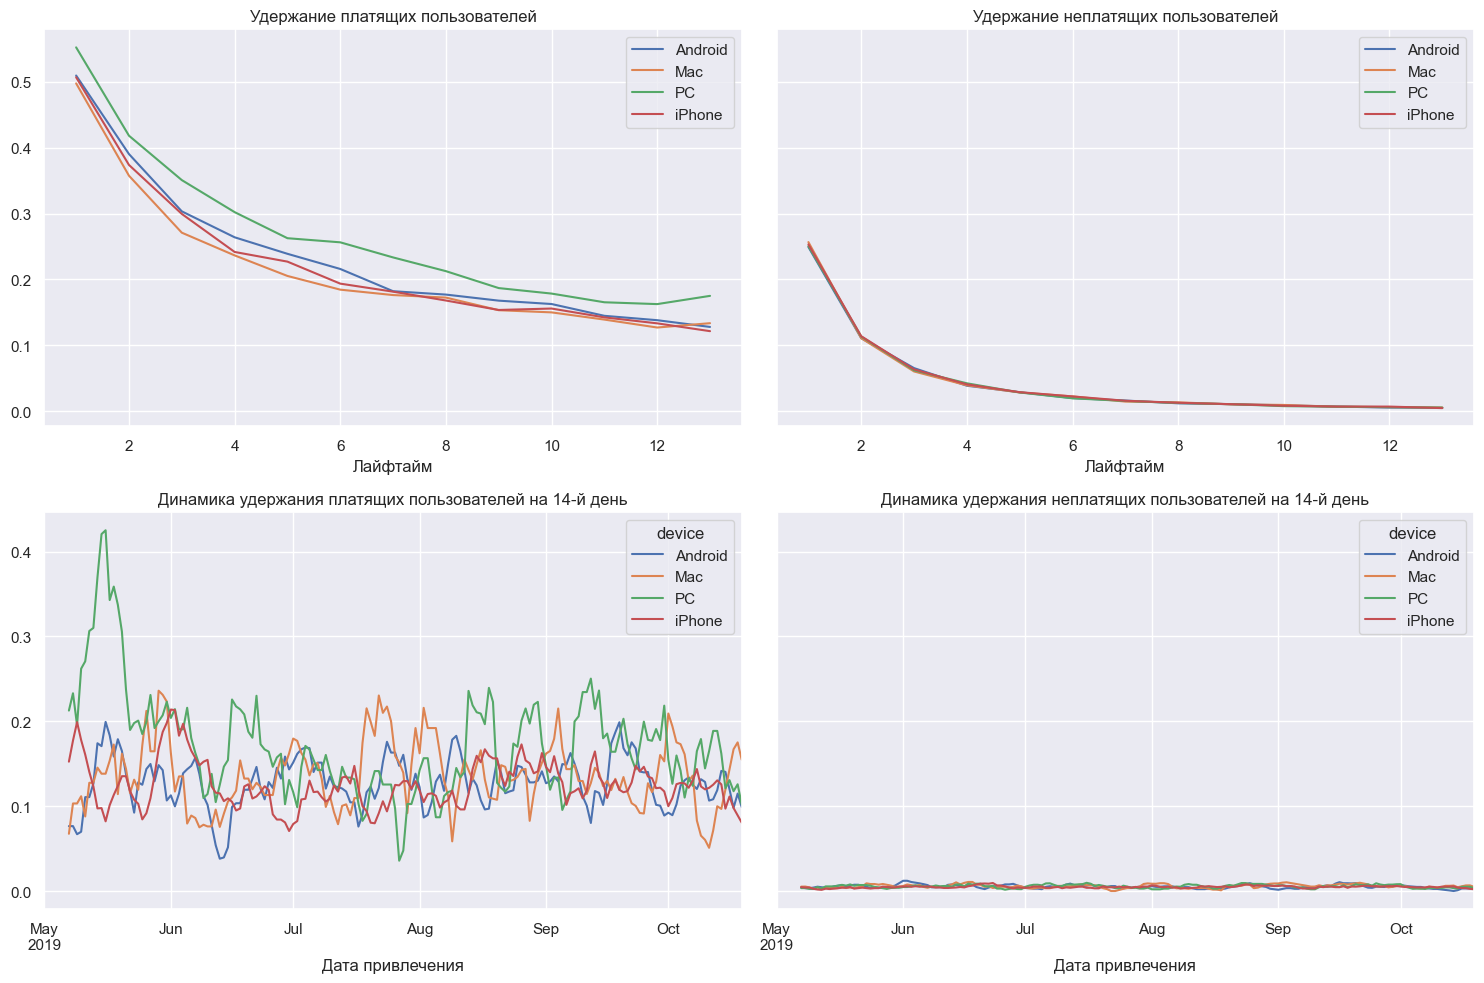

In [56]:
plot_retention(result_grouped, result_in_time, horizon_days, window=7)

Несмотря на меньшую долю платежеспособной аудитории у ПК, удержание этих платящих клиентов у него ощутимо выше, даже после старта активной рекламной кампании.

In [57]:
result_raw, result_grouped, result_in_time = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['device'],
    ignore_horizon=False,
)

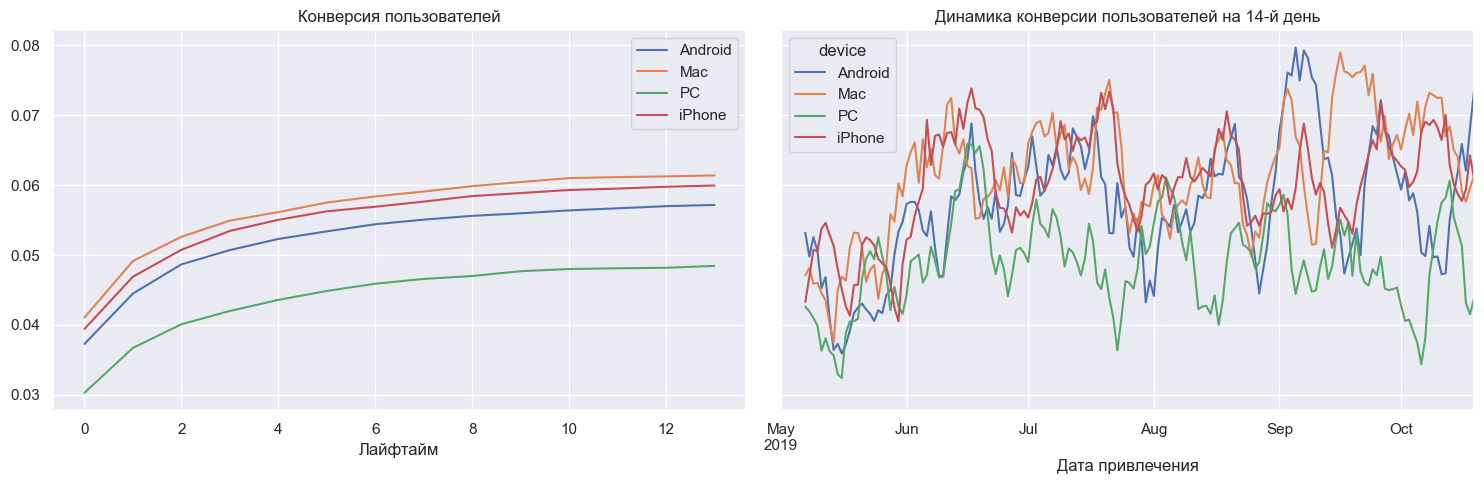

In [58]:
plot_conversion(result_grouped, result_in_time, horizon_days, window=7)

Логично ввиду меньшей доли платежеспособных клиентов у ПК, его конверсия меньше, и ровно наоборот у Apple.

[Вернуться к оглавлению](#table_of_contest)

<a id="by_country"></a>

### Проанализируйте окупаемость рекламы с разбивкой по странам

In [59]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history  = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['region'],
    ignore_horizon=False,
)

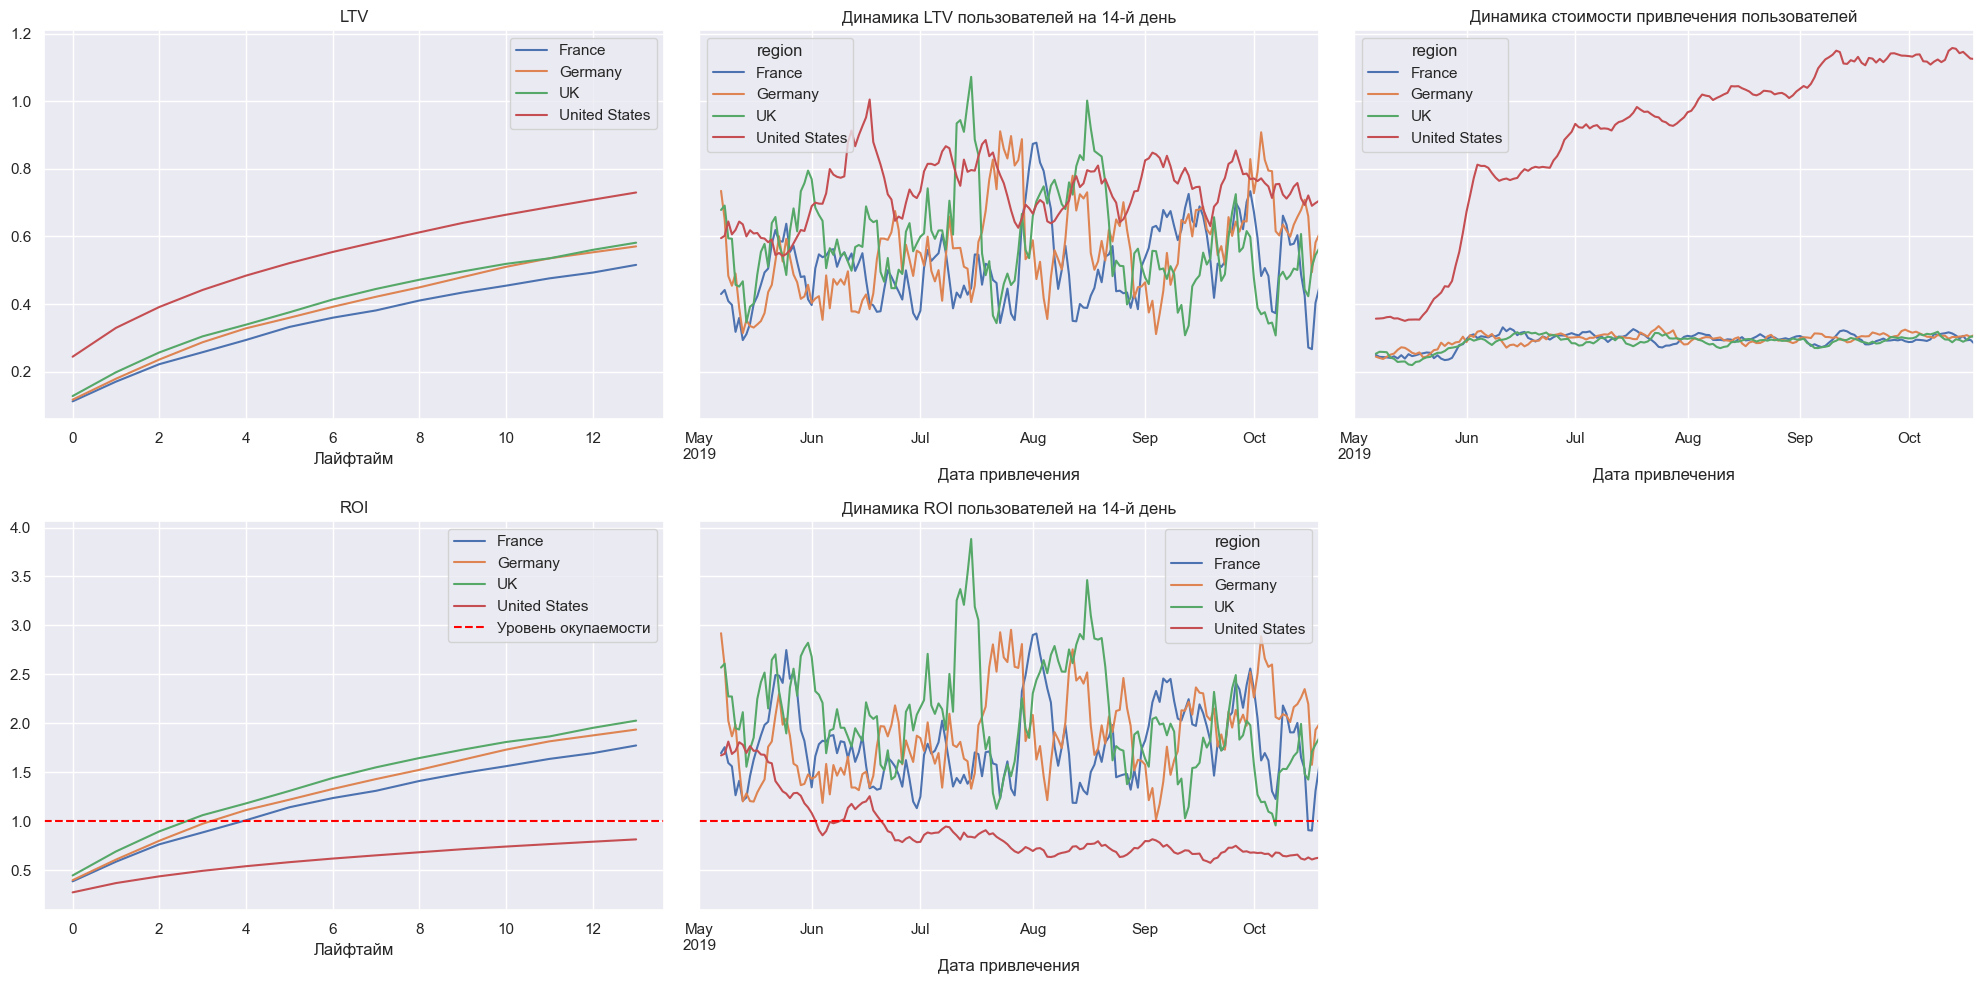

In [60]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Ситуация со странами абсолютно аналогична ситуации с устройствами, только вместо Apple здес США. Именно на пользователей из этой страны пришлись самые серьезные расходы на рекламу, которые в итоге не оправдали себя.

In [61]:
result_raw, result_grouped, result_in_time = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=['region'],
    ignore_horizon=False,
)

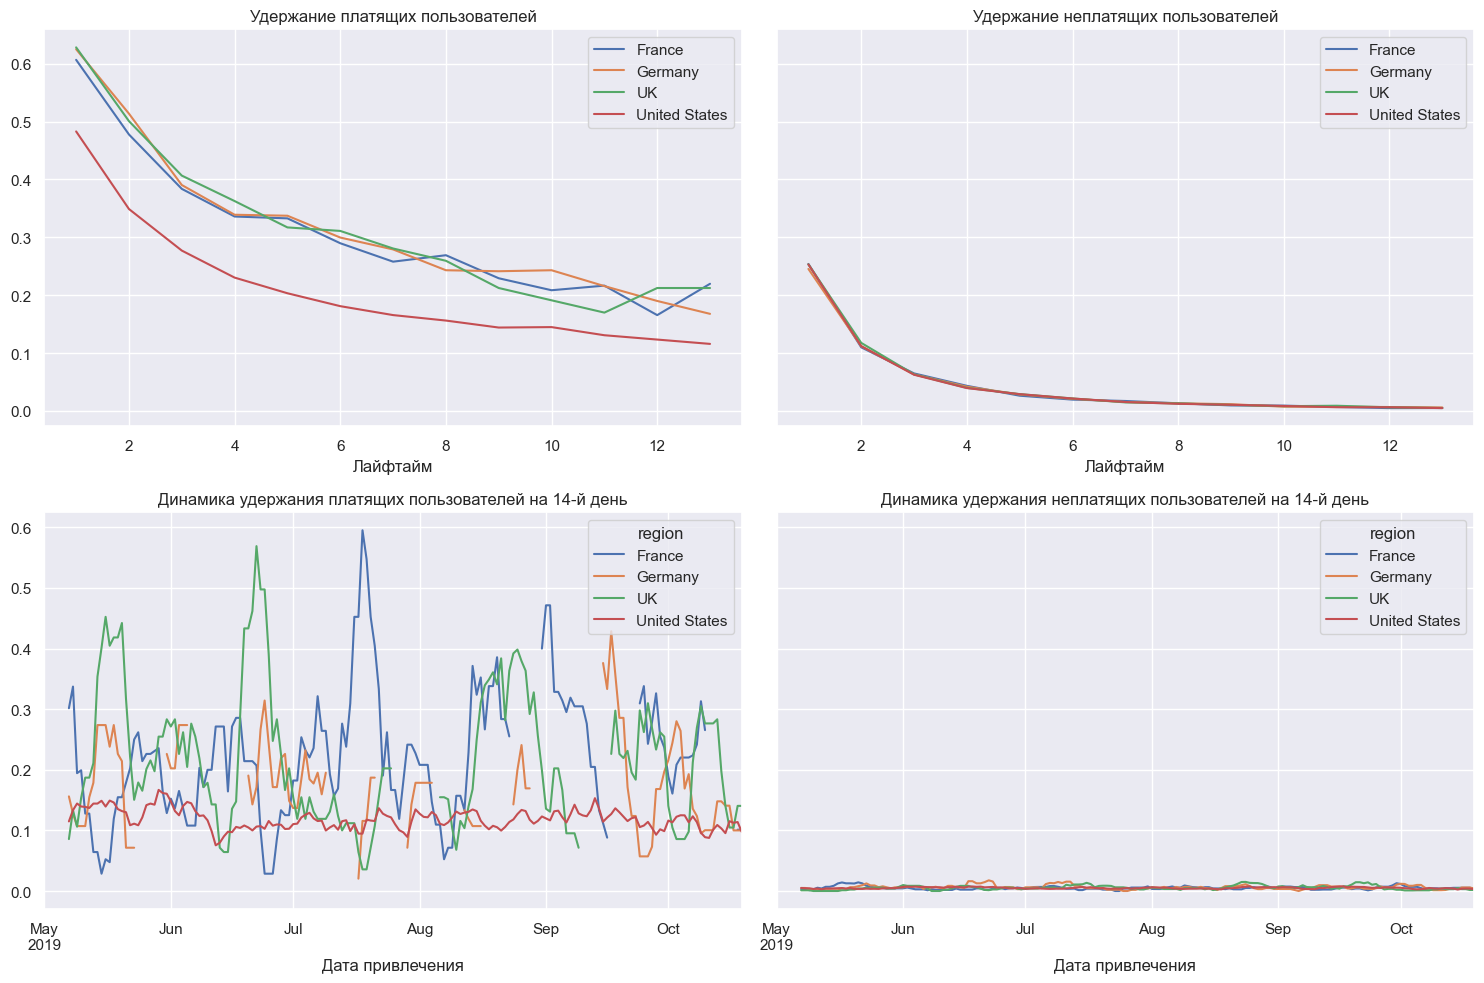

In [62]:
plot_retention(result_grouped, result_in_time, horizon_days, window=7)

Большое число пользователей из США, приходящие в результате рекламной кампании, не остаются с продуктом надолго.
Более того, рекламная кампания в принципе не привела из США пользователей лучшего качества, динамика удержания на 14 день в этой стране оставалась стабильно низкой на протяжении всего обозреваемого периода.

In [63]:
result_raw, result_grouped, result_in_time = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['region'],
    ignore_horizon=False,
)

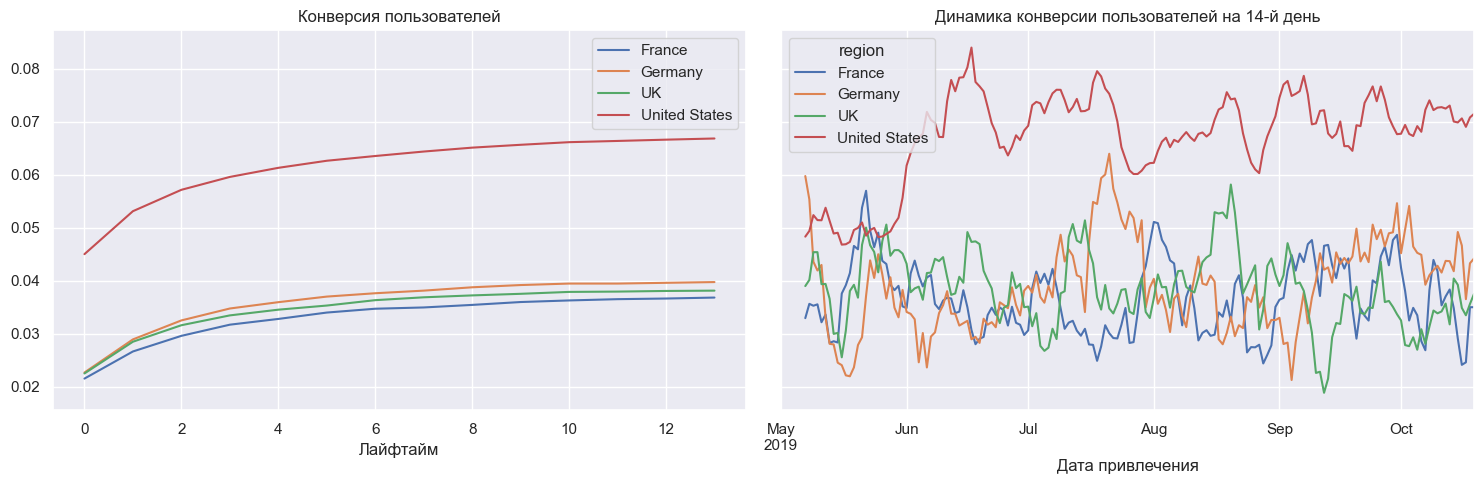

In [64]:
plot_conversion(result_grouped, result_in_time, horizon_days, window=7)

Однако, действительно так же как и у пользователей Apple, у американцев конверсия больше ввиду их больше платежеспособности. Но видимо сделав свои первые покупки они не остаются с продуктом надолго.

[Вернуться к оглавлению](#table_of_contest)

<a id="by_channels"></a>

### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам

In [65]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history  = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)

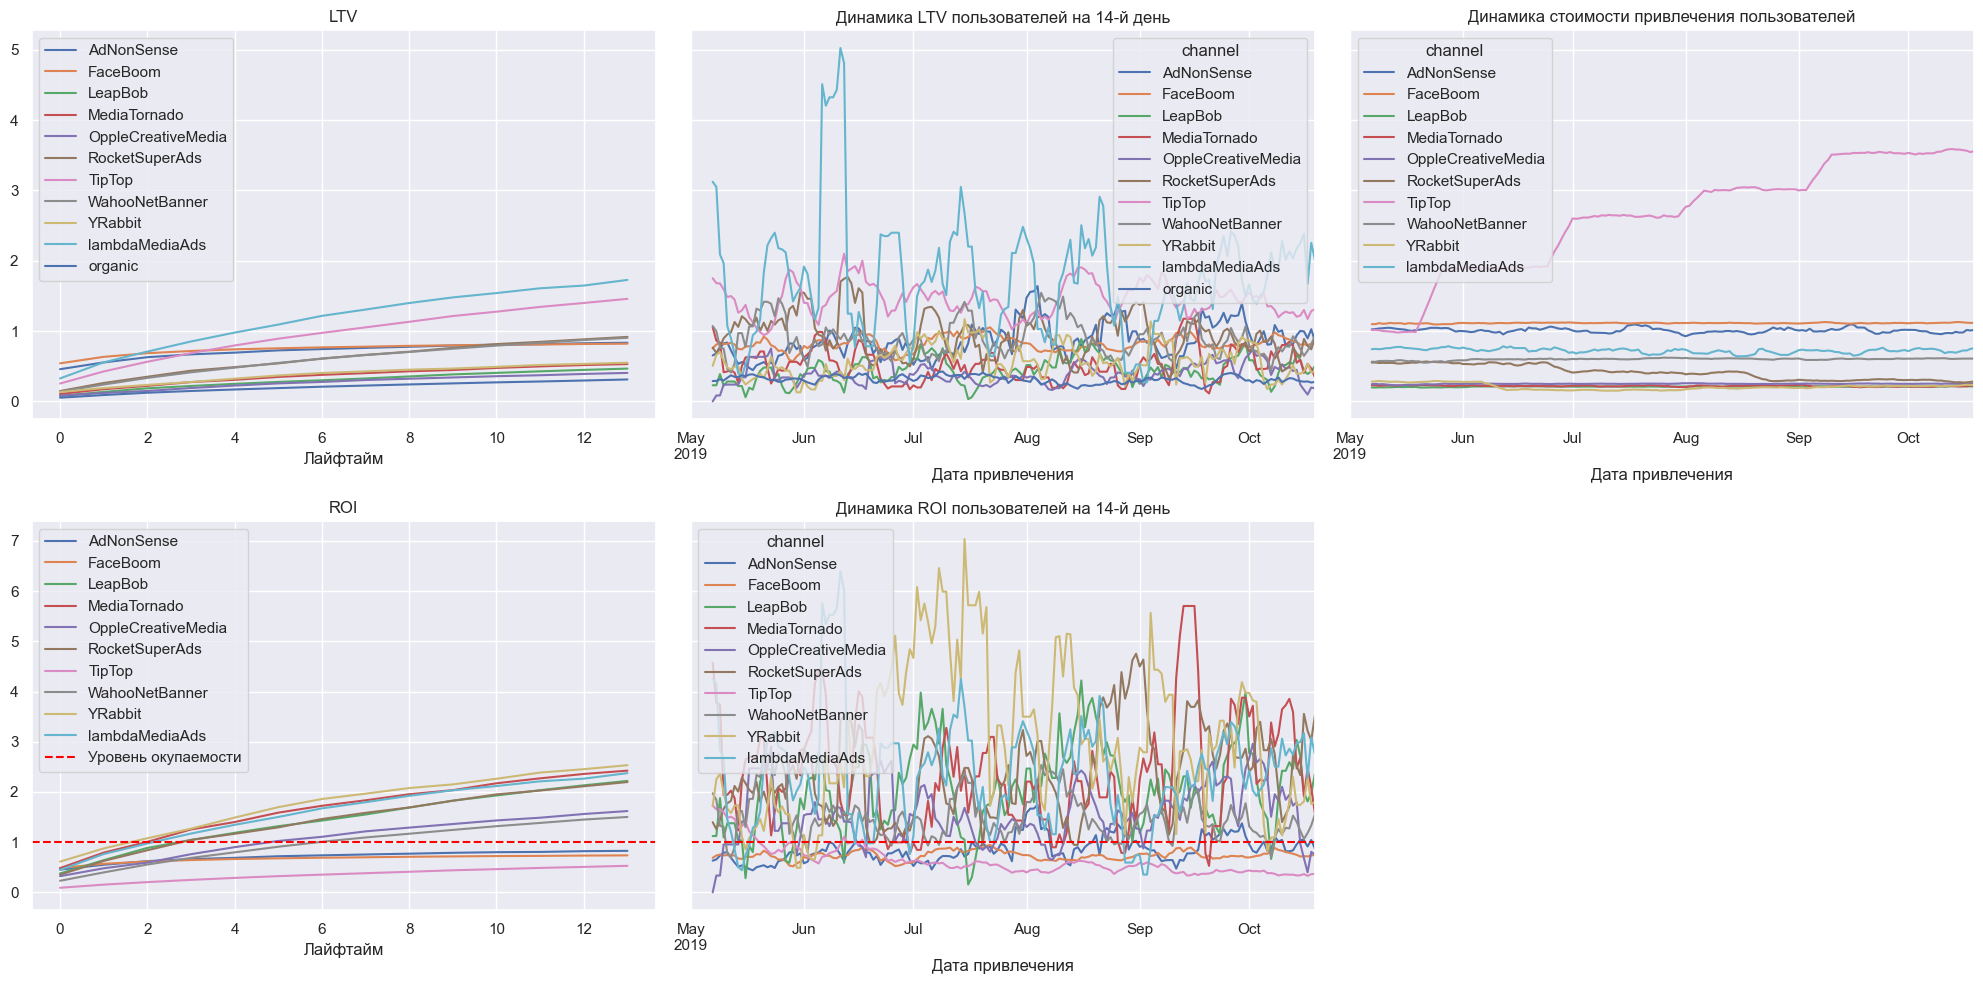

In [66]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Как мы и предсказывали ранее Тип-Топ - это наименее разумный способ расходования средств на рекламу. Именно на него пришлись огромные расходы, которые в итоге не принесли пользователей, чей ROI дотягивает до окупаемости.

In [67]:
result_raw, result_grouped, result_in_time = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)

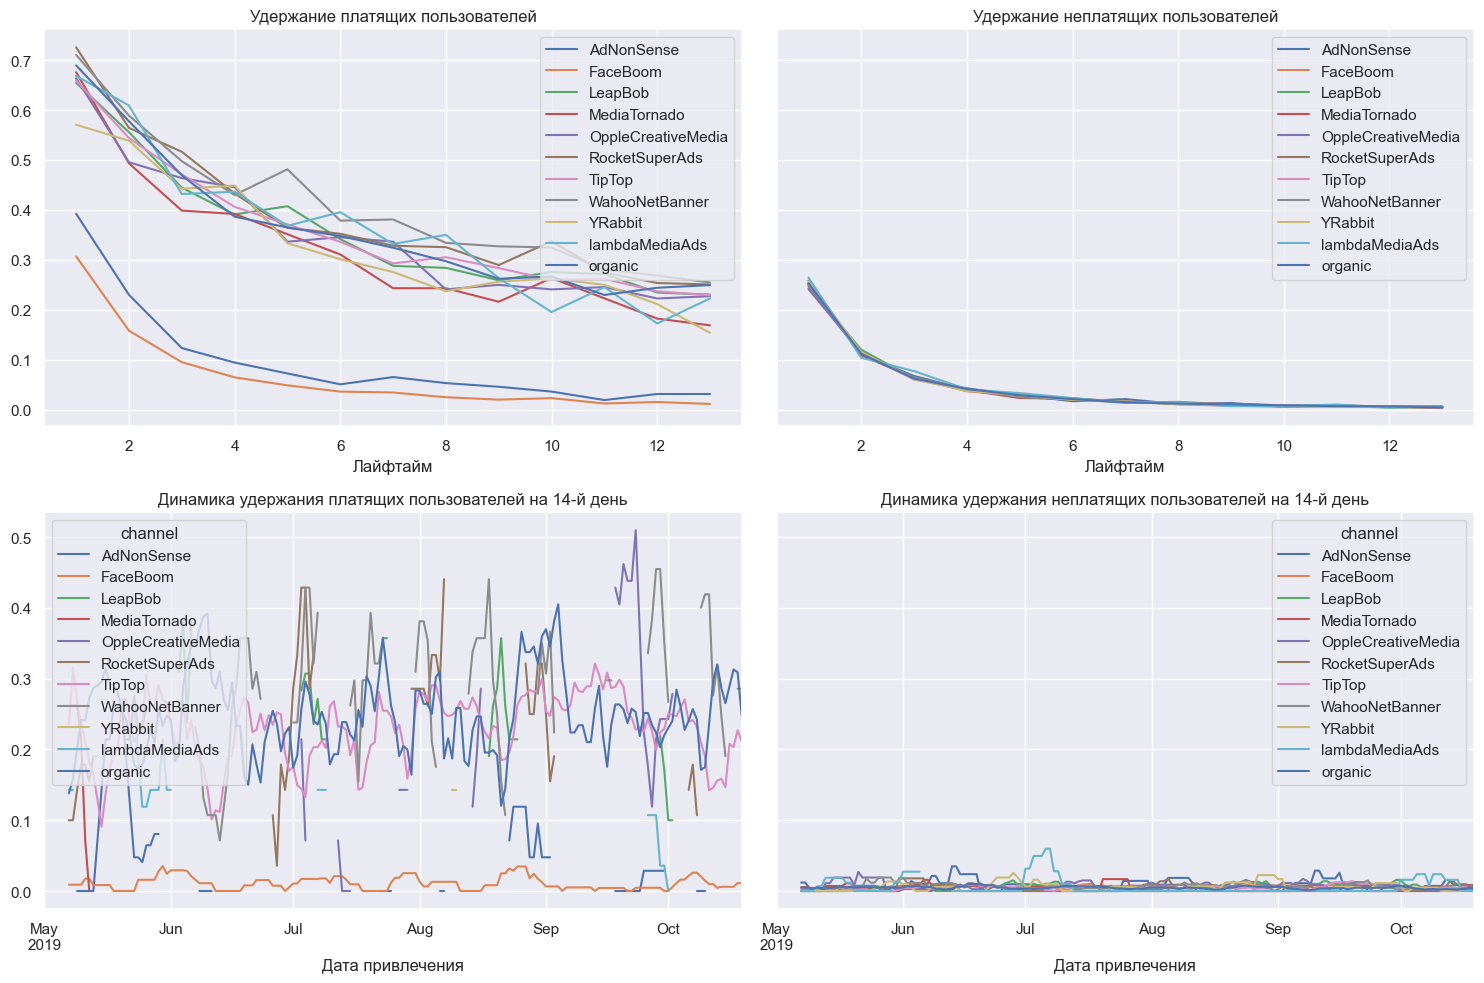

In [68]:
plot_retention(result_grouped, result_in_time, horizon_days, window=7)

Итого, можно сказать, что Фейсбум и Аднонсенс приводят клиентов, которые не остаются надолго. Типтоп имеет по этому показателю средние результаты, но при этом сам по себе является слишком дорогим.

In [69]:
result_raw, result_grouped, result_in_time = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)

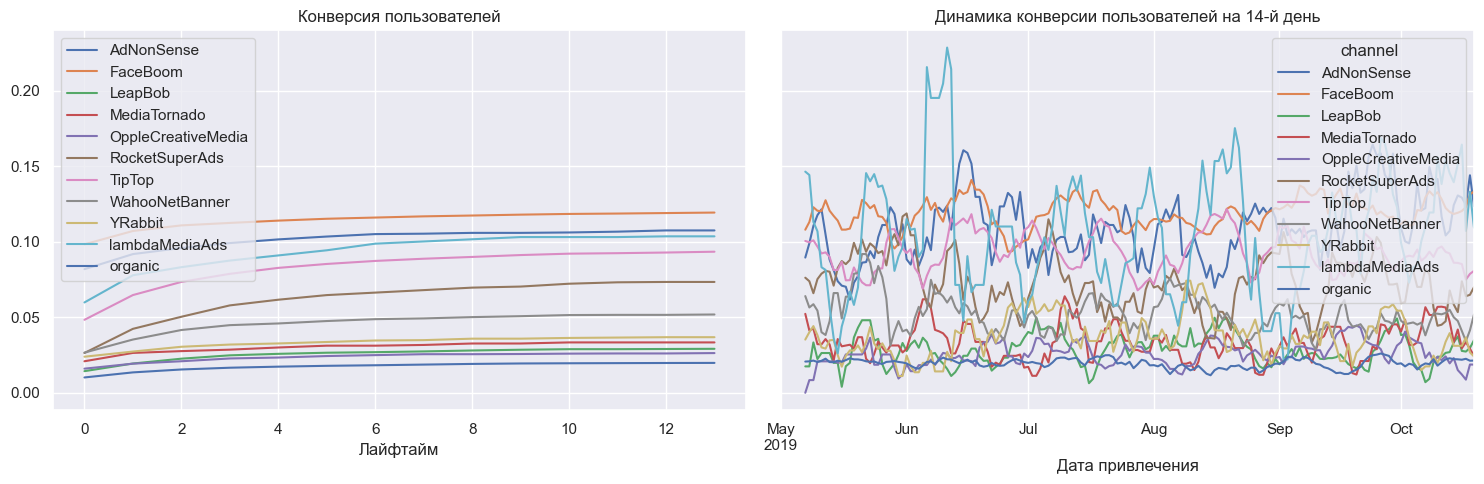

In [70]:
plot_conversion(result_grouped, result_in_time, horizon_days, window=7)

Пользователи, пришедшие из фейсбума и аднонсенса быстро конвертируются, платят, но также быстро уходят.

[Вернуться к оглавлению](#table_of_contest)

<a id="final_step"></a>

# Вывод
- Причины неэффективности привлечения пользователей;
- Рекомендации для отдела маркетинга для повышения эффективности.

<b>Причины неэффективности: <b>
    
Причина неэффективности достаточно очевидна. С опорой, видимо, в основном на такие показатели как LTV и доля платежеспособной аудитории, была сделана ставка на пользователей из США с техникой Apple через Тип-Топ. Однако, стоимость привлечения одного клиента через данный канал в разы превосходит все остальные. В связи с этим даже действительно высокий LTV среди данных категорий пользователей не смог оправдать затрат на их привлечение. 

Несколько меньшая проблема - это низкое качество клиентов, приводимых Фейсбумом и Аднонсенсом - двумя другими крупными каналами рекламы. Эти каналы дешевле, у них лучше конверсия, но гораздо меньше удержание. 

<b>Рекомендации: <b>
    
    * Перестать держать Тип-Топ в качестве приоритетного канала рекламы - он слишком дорогой, а пользователи, пришедшие через него демонстрируются слишком средние результаты, не позволяющие окупать инвестиции в них.
    * В краткосрочной перспективе поддерживать инвестиции в Фейсбум на текущем уровне, так как он крупный канал, который все-таки окупается. В долгосрочной необходимо понять, почему клиенты, пришедшие через него так быстро уходят, и либо решить проблему, либо уменьшить приоритет данного канала.
    * В долгосрочной перспективе наращивать инвестиции в другие каналы рекламы, обладающие лучшими показателями, например, в YRabbit, MediaTornado, LambdaMediaAds.

[Вернуться к оглавлению](#table_of_contest)